12


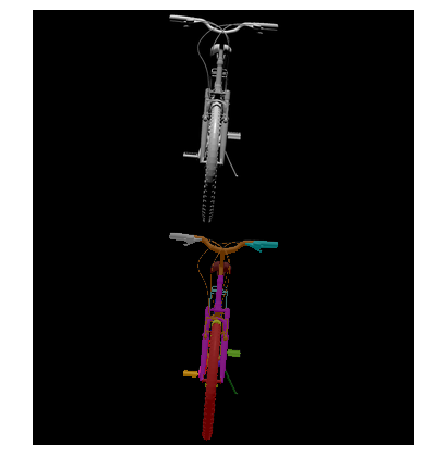

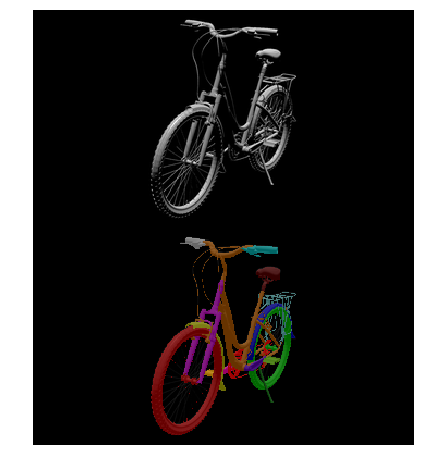

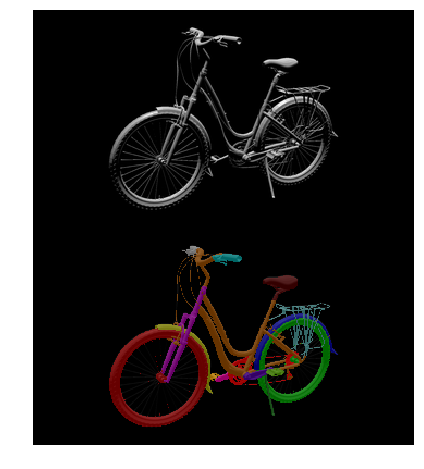

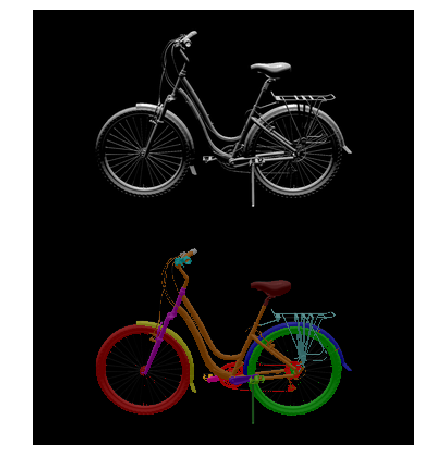

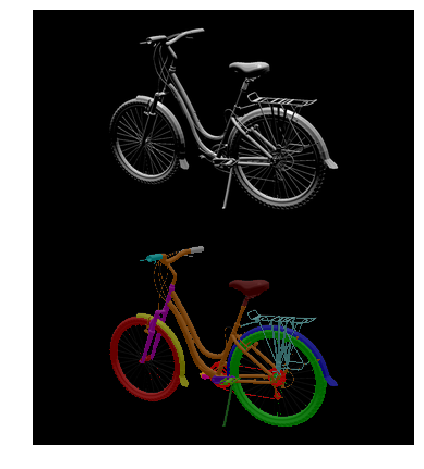

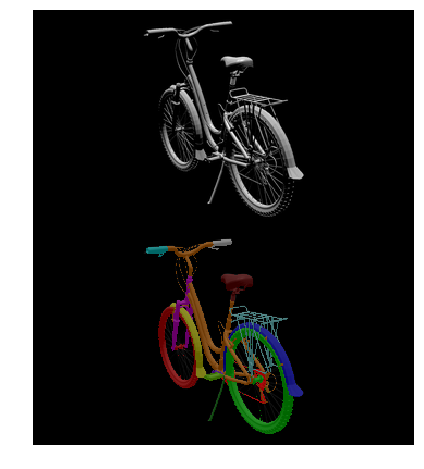

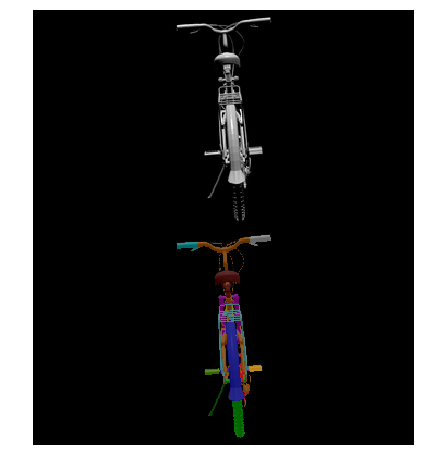

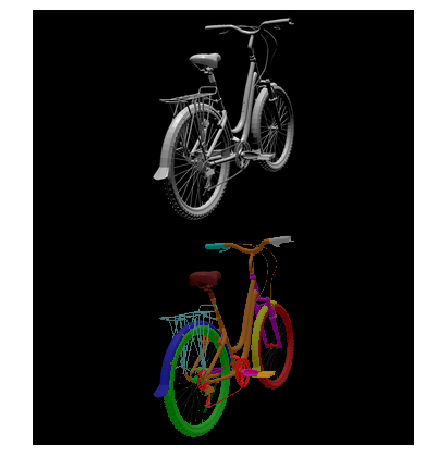

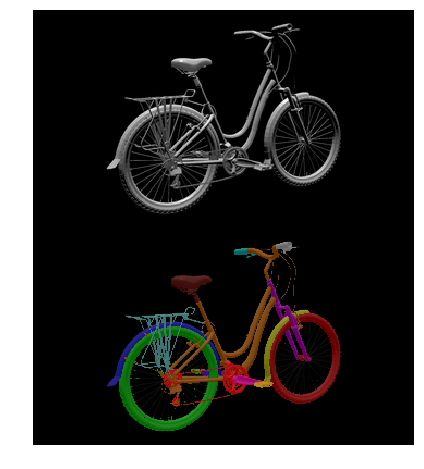

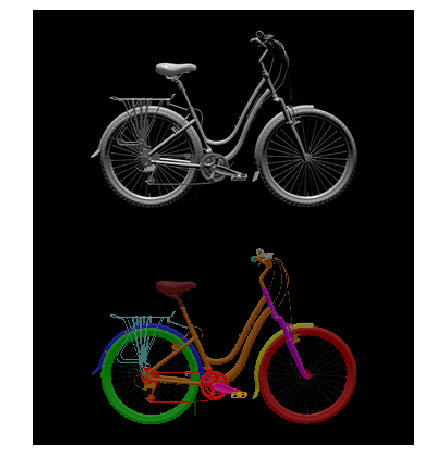

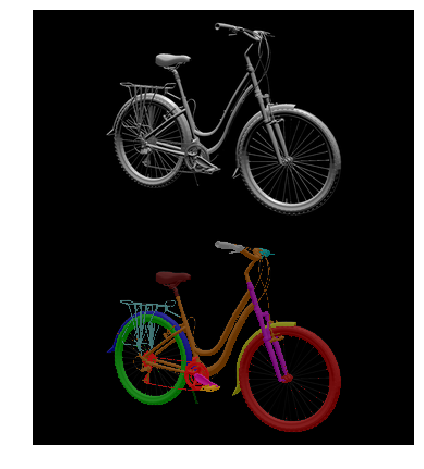

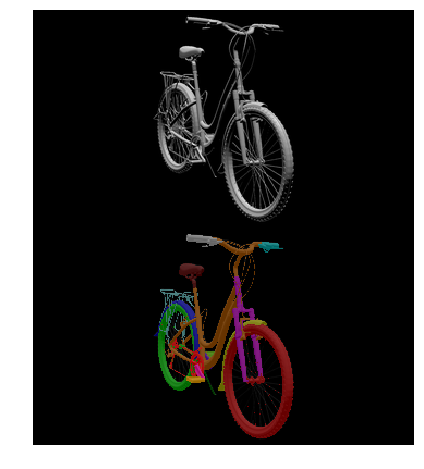

In [21]:
import glob,os
import scipy.io as sio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def resize(image, mask, resize=800):
    width, height = mask.size
    alpha_idx = np.where(np.array(mask) != 0)
    min_y, min_x = np.min(alpha_idx, axis=1)
    max_y, max_x = np.max(alpha_idx, axis=1)
    diff_y, diff_x = max_y-min_y, max_x-min_x
    ctr_y, ctr_x = (min_y+max_y)/2, (min_x+max_x)/2
    y1,y2 = max(0,int(ctr_y-diff_y*0.6)), min(int(ctr_y+diff_y*0.6), height)
    x1,x2 = max(0,int(ctr_x-diff_x*0.6)), min(int(ctr_x+diff_x*0.6), width)
    image = image.crop((x1, y1, x2, y2))
    mask = mask.crop((x1, y1, x2, y2))

    scl = resize/max(y2-y1, x2-x1)
    new_size = (int((x2-x1)*scl), int((y2-y1)*scl))
    image = image.resize(new_size, Image.ANTIALIAS)
    mask = mask.resize(new_size, Image.NEAREST)
    return image, mask

def center_crop(image, mask, crop=(1610,920), resize=(350,200)):
    width, height = mask.size
    alpha_idx = np.where(np.array(mask) != 0)
    min_y, min_x = np.min(alpha_idx, axis=1)
    max_y, max_x = np.max(alpha_idx, axis=1)
    diff_y, diff_x = max_y-min_y, max_x-min_x
    ctr_y, ctr_x = (min_y+max_y)/2, (min_x+max_x)/2
    y1,y2 = max(0,int(ctr_y-crop[1]*0.5)), min(int(ctr_y+crop[1]*0.5), height)
    x1,x2 = max(0,int(ctr_x-crop[0]*0.5)), min(int(ctr_x+crop[0]*0.5), width)
    image = image.crop((x1, y1, x2, y2))
    mask = mask.crop((x1, y1, x2, y2))
    image = image.resize(resize, Image.ANTIALIAS)
    mask = mask.resize(resize, Image.NEAREST)
    
    return image, mask

cmap = sio.loadmat('../DeepLabv3.pytorch/data/pascal_seg_colormap.mat')['colormap']
cmap = (cmap * 255).astype(np.uint8).flatten().tolist()

cls='bicycle'
model_id='42th1K3l6c'
data_root = './demo/{}/'.format(cls)
img_dir = os.path.join(data_root, 'image', model_id)
anno_dir = os.path.join(data_root, 'seg', model_id)

file_ls = glob.glob(os.path.join(anno_dir, '*.png'))
file_ls = sorted(file_ls)
print(len(file_ls))
merge_ls = []
for ff in file_ls:
    file_name = ff.split('/')[-1]
    
    img=Image.open(os.path.join(img_dir, file_name))
    img=img.convert('RGB')
    anno=Image.open(ff)
    img,anno = center_crop(img,anno)
    anno.putpalette(cmap)
    anno=anno.convert('RGB')

    merged=(np.array(img)*0.2+np.array(anno)*0.8).astype(np.uint8)
    merge_ls.append(Image.fromarray(merged))

    ret=np.concatenate([np.array(img), merged],axis=0)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(ret)
    plt.show()

In [25]:
merge_ls[0].save('./demo/{}/demo.gif'.format(cls), save_all=True, append_images=merge_ls[1:],duration=1000, loop=0)